In [49]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
reviews = pd.read_csv(r'../data/restaurant_reviews_upd.csv')
reviews.head(2)

,Restaurant,Reviewer,Review,Rating,Time,Pictures,prev_reviews_count,followers_count,Month,DayOfWeek
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,2019-05-25 15:54:00,0,1,2,5,Saturday
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,2019-05-25 14:20:00,0,3,2,5,Saturday


In [32]:
restaurant_data = pd.read_csv('../data/restaurant_detail_upd.csv')
# convert string to lit
restaurant_data['Cuisine_List'] = restaurant_data['Cuisine_List'].apply(ast.literal_eval)
restaurant_data.head(2)

,Name,Cost,Cuisine_List
0,Beyond Flavours,800,"[chinese, continental, kebab, european, southi..."
1,Paradise,800,"[biryani, northindian, chinese]"


In [33]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
features = mlb.fit_transform(restaurant_data['Cuisine_List'])

features_df = pd.DataFrame(features, columns=mlb.classes_)

features_df['Cost'] = restaurant_data['Cost']
features_df['Name'] = restaurant_data['Name']

# features_df.head()
features_df.set_index('Name',inplace=True)
features_df.head(2)

,american,andhra,arabian,asian,bakery,bbq,beverages,biryani,burger,cafe,...,pizza,salad,seafood,southindian,spanish,streetfood,sushi,thai,wraps,Cost
Name,,,,,,,,,,,,,,,,,,,,,
Beyond Flavours,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,800
Paradise,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,800


In [34]:
features_df['Avg_Rating'] = reviews.groupby('Restaurant')['Rating'].mean()
features_df.head(10)

# take over the null values
features_df['Avg_Rating'] = features_df['Avg_Rating'].fillna(features_df['Avg_Rating'].mean())
features_df['Cost'] = features_df['Cost'].fillna(features_df['Cost'].mean())

In [44]:
# finding most important cuisinea
selected_features = features_df.columns[features_df.sum(axis=0) > 7].to_list()
selected_features

['asian',
 'biryani',
 'chinese',
 'continental',
 'desserts',
 'fastfood',
 'italian',
 'northindian',
 'southindian',
 'Cost',
 'Avg_Rating']

### ML Model Implementation

- The ML model used is K-Means clustering. K-Means is an unsupervised learning algorithm used for clustering data points into K clusters based on similarity.

- The performance of the K-Means model can be evaluated using two main metrics: inertia and silhouette score.
    - Inertia represents the sum of squared distances of samples to their closest cluster center. Lower inertia values indicate tighter clusters.

    - Silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Higher silhouette scores indicate better-defined clusters.

- Based on the provided data:
    - Inertia values decrease as the number of clusters (K) increases, which is expected. However, the rate of decrease slows down as K increases.
    - Silhouette scores also increase with the number of clusters, indicating better-defined clusters.

- By analyzing both metrics, we can determine the appropriate number of clusters that provide a good balance between tight clustering (low inertia) and well-separated clusters (high silhouette score).

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(features_df[selected_features])

cluster_range = range(2,15)
inertia_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters,init='k-means++',random_state=43)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    

c:\Users\Nitin Flavier\Desktop\Data Nexus\Data Science\ML_BootCamp\ML_Projects\Zomato_Insights\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Nitin Flavier\Desktop\Data Nexus\Data Science\ML_BootCamp\ML_Projects\Zomato_Insights\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Nitin Flavier\Desktop\Data Nexus\Data Science\ML_BootCamp\ML_Projects\Zomato_Insights\venv\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Nitin Flavier\Desktop\Data Nexus\Data Science\ML_BootCamp\ML_Projects\Zomato_Insights\ven

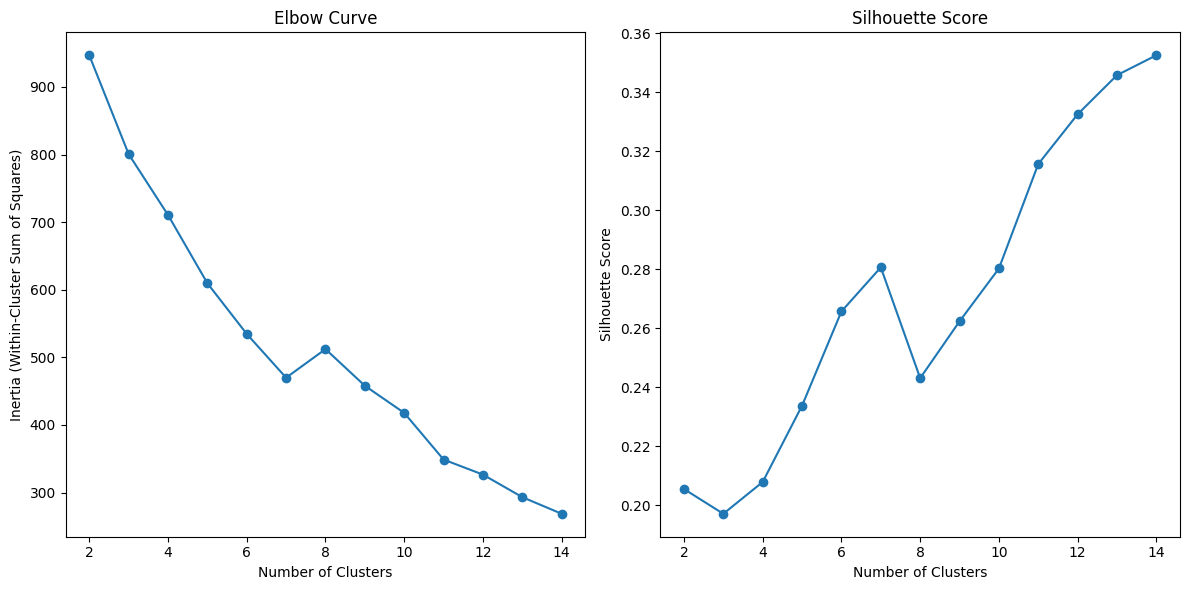

Optimal number of clusters: 14


In [50]:

# Plot the elbow curve to find the optimal number of clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')

# Plot the silhouette score to evaluate cluster quality
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Based on the plots, you can choose the optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")